<a href="https://colab.research.google.com/github/vbwanere/SEDS_in_jax/blob/main/gmr_lib/GMR_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GMR**

Gaussian Mixture Regression Model

# 1\. Introduction:

We estimate a joint density of the inputs $x\  \epsilon \ \mathbb R^N$ and outputs $\dot x \ \epsilon \ \mathbb R^P$ through a K-component Gaussian mixture model as follows:

\begin{equation}
\tag{1}
p(x, \dot x|\Theta) = \sum_{k=1}^{K} \pi_k p(x, \dot x|\mu^k \Sigma^k)
\end{equation}

where,\
$\sum_{k=1}^{K} \pi_k = 1$ and $\mu^k = \begin{bmatrix}
\mu_{x}^{k}\\
\mu_{\dot x}^{k}
\end{bmatrix}$,
and $\ \Sigma^k =
\begin{bmatrix}
\Sigma_{xx}^{k} & \Sigma_{x\dot x}^{k} \\
\Sigma_{\dot xx}^{k} & \Sigma_{\dot x \dot x}^{k}
\end{bmatrix}$.

The conditional density is given by:
\begin{equation}
\tag{2}
p(\dot x|x) = \sum_{k=1}^{K} \gamma_k p(y|x;\mu^k \Sigma^k)
\end{equation}

where,
\begin{equation}
\tag{3}
\gamma_k = \frac{\pi_k p(x|\mu_x^k, \Sigma_{xx}^k)}{\sum_{k=1}^{K} \pi_k p(x|\mu_x^k, \Sigma_{xx}^k)}
\end{equation}

The regressive function $\dot x = f(x)$ is given by the expectation over this conditional density:
\begin{equation}
\tag{4}
\dot x = f(x) = \mathbf E[p(\dot x|x)] = \sum_{k=1}^{K} \gamma_k(x)\tilde \mu^k(x)
\end{equation}

where,
\begin{equation}
\tag{5}
\tilde \mu = \mu_{\dot x}^k + \Sigma_{\dot x x}^k(\Sigma_{x x}^k)^{-1}(x - \mu_x^k)
\end{equation}

If we use change of variable and define:

\begin{equation}
\tag{6}
\!
\begin{aligned}
A^k & = \Sigma_{\dot x x}^k(\Sigma_{x}^k)^{-1}\\
b^k & = \mu_{\dot x}^k\\

\gamma_k & = \frac{\pi_k p(x|\mu_x^k, \Sigma_{xx}^k)}
{\sum_{k=1}^{K} \pi_k p(x|\mu_x^k, \Sigma_{xx}^k)}\\
\end{aligned}
\end{equation}

Substituting (6) in (4) and using (5) yields:

\begin{equation}
\tag{7}
\!
\begin{aligned}
\dot x & = f(x; \Theta_{GMR})\\
& = \mathbf E[p(\dot x|x)] = \sum_{k=1}^{K} \gamma_k(x) (A^k_x + b^k)
\end{aligned}
\end{equation}

Also, we can write a non linear dynamical system as a mixture of linear dynamical systems as follows:

\begin{equation}
\tag{8}
\!
\begin{aligned}
\dot x & = f(x)\\
& = \sum_{k=1}^{K} \gamma_k(x) (A^k_x + b^k)
\end{aligned}
\end{equation}

where $A^k \ \epsilon \ \mathbb{R^N}$ and $b^k \ \epsilon \ \mathbb{R^N}$ are the k-th linear system parameters. $\gamma_k(x): \mathbb{R^N} \rightarrow \mathcal{R}$ is the mixing function, also referred to as the activation function. Please refer to the figure below:

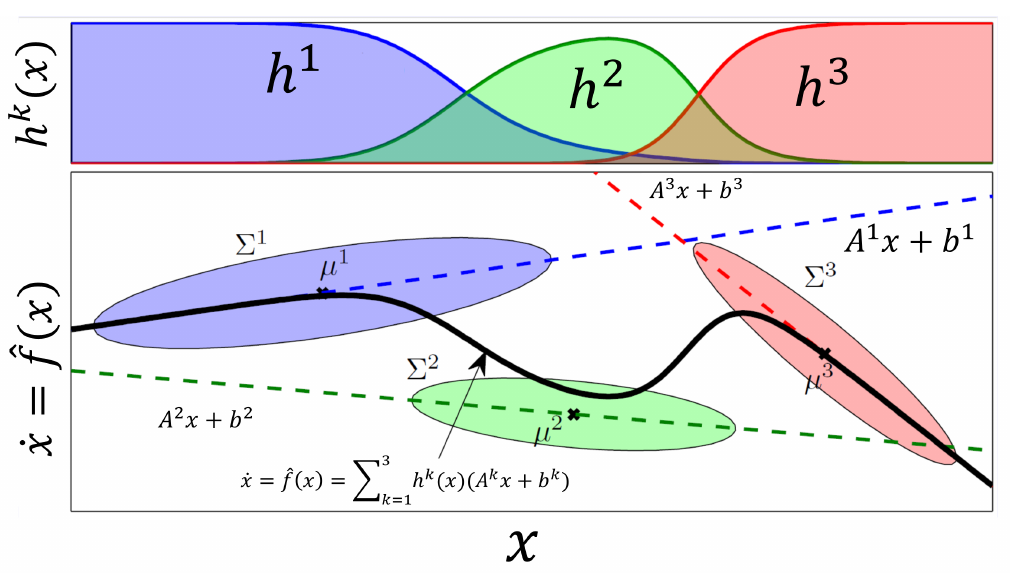\
Figure: Illustration of parameters defined in (6) and their effects on $f(x)$ for a 1-D model\
constructed with 3 Gaussians. $h(x)$ is the activation function.

## 1.1 Undestanding the dataset:

1. Inputs $x \ \epsilon \ \mathbb R^N$, for $M$ number of trajectories with each of length $T_m$, we have, for $m^{th}$ trajectory:
\begin{equation}
X_m =
\begin{bmatrix}
x_1^1 & x_1^2 & ....... & x_1^{T_m}\\
& & &\\
x_N^1 & x_N^2 & ....... & x_N^{T_m}\\
\end{bmatrix}
\end{equation}

where, $m \ \epsilon \  \{1,....,M\}$, and $\{\mathbf X, \dot{\mathbf X}\} = \{X^m, \dot X^m\}_{m=1}^{M} = \{\{{x^{t,m}, {\dot x^{t,m}}\}_{t=1}^{T_m}}\}_{m=1}^{M}$.

In our python implementation, the $X^m$ is an array of shape $(N, T^m)$ and the dataset for all trajectories is a list with $M$ such arrays.

# 2. Using `gmr` library:

In [1]:
import numpy as np
# import jax.numpy as jnp
# from jax import grad, jacfwd, jit, random, vmap
# from jax.scipy.stats import multivariate_normal
from sklearn import mixture
import scipy
import scipy.io
import pprint as pp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools
import os

Please refer to the [this GMR library by Alexander Fabisch](https://github.com/AlexanderFabisch/gmr).

In [2]:
from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses

## 2.1 Importing LASA Handwritten Dataset:
Please refer to [this python library](https://github.com/justagist/pyLasaDataset) for the [Handwritten Human Motion LASA Datset](https://www.epfl.ch/labs/lasa/datasets/).\
Please understand the dataset [here](https://bitbucket.org/khansari/lasahandwritingdataset/src/master/Readme.txt).

In [3]:
from pyLasaDataset import DataSet as lasa
from pyLasaDataset import utilities
plot_lasa = utilities.plot_model

Using LASA DataSet from /usr/local/lib/python3.11/dist-packages/pyLasaDataset-0.1.1-py3.11.egg/pyLasaDataset/resources/LASAHandwritingDataset/DataSet


## 2.2 Visualizing Trajectories:

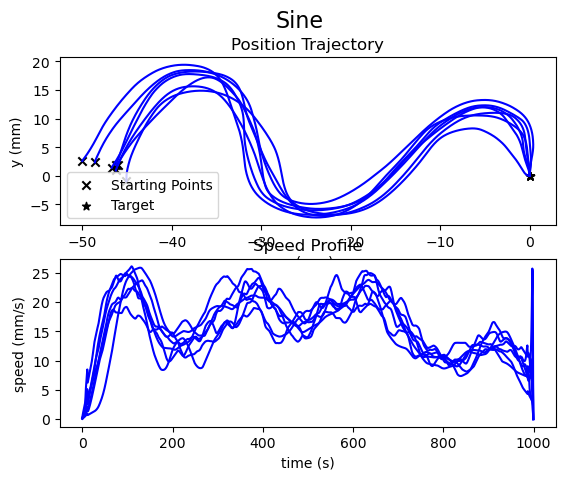

In [4]:
sine = lasa.Sine
plot_lasa(sine)

## 2.3 Fitting GMM on a given trajectory data:

#### 2.3.1 Position and Velocity Datset

In [5]:
# function: get_traj_data

def get_traj_data(trajectory_name = 'Sine'):
    """
    Returns position and velocity data of the trajectory.
    shape: (M*T, 4) --> [x_pos, y_pos, x_vel, y_vel]
    M: number of demonstrations
    T: number of time steps t=0 to t=T
    """
    traj_demos = getattr(lasa, trajectory_name).demos
    
    traj_pos = traj_demos[0].pos.T # trajectory position shape: (T, 2)
    traj_vel = traj_demos[0].vel.T # trajectory position shape: (T, 2)
    
    # positions of all demonstrations:
    for i in range(len(traj_demos)-1):
        concat_pos = np.concatenate((traj_pos, (traj_demos[i+1].pos.T)), axis= 0 )
        traj_pos = concat_pos
    
    # velocities of all demonstrations:
    for i in range(len(traj_demos)-1):
        concat_vel = np.concatenate((traj_vel, (traj_demos[i+1].vel.T)), axis= 0 )
        traj_vel = concat_vel    
    
    # trajectory position and velocity: trajectory_dynamics:
    traj_dynamics = np.concatenate((traj_pos, traj_vel), axis=1)
    
    return traj_dynamics

In [6]:
traj_dynamics = get_traj_data('CShape')
# plt.scatter(angle_dynamics[:, 0], angle_dynamics[:, 1], c='r', marker = '.', s=0.8)

#### 2.3.2 Fitting gmm:

In [7]:
gmm = GMM(n_components=4, random_state=0)
gmm.from_samples(traj_dynamics)
traj_k = np.argmax(gmm.to_responsibilities(traj_dynamics), axis=1)

#### 2.3.3 Predicting Velocities using GMR:

In [8]:
def pred_vel(trajectory_name = 'Sine', grid_size = 50):
    
    """
    This function predicts the velocity of the trajectory using GMM.
    Input: trejectory_name: name of the trajectory.
    grid_size: number of points in each dimension.
    
    Output: a list of arrays [pred_vel_u, pred_vel_v]
            pred_vel_u: u component, shape = (grid_size, grid_size)
            pred_vel_v: v component, shape = (grid_size, grid_size)
    """
    
    traj_dynamics = get_traj_data(trajectory_name)
    # Define the range and number of points for x and y
    x_start, x_end = traj_dynamics[:, 0].min(), traj_dynamics[:, 0].max()
    y_start, y_end = traj_dynamics[:, 1].min(), traj_dynamics[:, 1].max()

    # Generate the grid dataset using np.linspace
    x = np.linspace(x_start, x_end, grid_size)
    y = np.linspace(y_start, y_end, grid_size)

    # Create a meshgrid from the x and y values
    x_grid, y_grid = np.meshgrid(x, y)

    # Flatten the grids to create the dataset
    x_dataset = x_grid.flatten()
    y_dataset = y_grid.flatten()

    # Combine x and y values to create the final 2D dataset
    test_pos = np.column_stack((x_dataset, y_dataset))
    
    # predict velocity using gmr:
    pred_vel = gmm.predict(np.array([2, 3]), test_pos)

    # u component of velocity
    pred_vel_u = pred_vel[:, 0].reshape(x_grid.shape)

    # v component of velocity
    pred_vel_v = pred_vel[:, 1].reshape(x_grid.shape)

    return [x_grid, y_grid, pred_vel_u, pred_vel_v]

In [9]:
pos_vel = pred_vel('CShape')

#### 2.3.3 Plotting Predicted Velocities Streamlines:

In [10]:
# Function for plotting Guassian Ellipses:

def plot_gmm(mean, cov, color='k'):
    """Plot a single gaussian component"""
    # Get the eigenvalues and eigenvectors
    eigen_vals, eigen_vecs = np.linalg.eig(cov)

    # Get the index of the largest eigenvalue 
    idx = eigen_vals.argsort()[::-1] 
    eigen_vals, eigen_vecs = eigen_vals[idx], eigen_vecs[:,idx]

    theta = np.degrees(np.arctan2(eigen_vecs[:, 0][::-1]))

    # Ellipse properties 
    width, height = 2 * np.sqrt(eigen_vals)
    ellipse = patches.Ellipse(mean, width, height, angle=theta, facecolor='none', edgecolor=color)
    # ellipse.set_linestyle('--')
    ellipse.set_linewidth(4)
    return ellipse

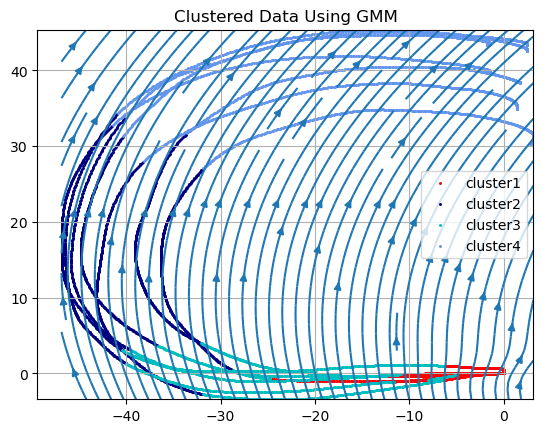

In [11]:
# color for each component:
color_iter_data = itertools.cycle(["red", "navy", "c", "cornflowerblue", "gold",\
    "darkorange", "green", "blue", "purple", "pink"])

# color for Gaussian ellipses:
color_iter_gmm = itertools.cycle(["green", "yellow", "black", "cornflowerblue", "gold"])


# plt.figure(figsize=(10, 10))
fig, ax = plt.subplots()
# plotting clustered datapoints for each component in loop:
for i in range(gmm.n_components):
    ax.scatter(traj_dynamics[:, :2][traj_k == i, 0],\
        traj_dynamics[:, :2][traj_k == i, 1], s=5,\
        c=next(color_iter_data), marker='.', label='cluster' + str(i + 1))

# plotting Gaussian ellipses for each component in a loop:
# for i in range(gmm.n_components):
    # ellipse = plot_gmm(gmm.means[i], gmm.covariances[i], color=next(color_iter_gmm))
    # ax.add_patch(ellipse)

# plottin streamlines for predicted velocities:
ax.streamplot(pos_vel[0], pos_vel[1], pos_vel[2], pos_vel[3], density=1.3)

plt.title('Clustered Data Using GMM')
plt.legend(scatterpoints=1)
plt.grid()

plt.show()

# 3. Using SEDS Algorithm to fit the GMR on the dataset:

## 3.1 SEDS Solver using `ipyopt`:

Please refer to [ipyopt](https://pypi.org/project/ipyopt/); a python implementation  of [ipopt](https://github.com/coin-or/Ipopt).

### 3.1.1 Objective Function:

\begin{equation*}
\begin{aligned}
& \underset{\Theta_{GMR}} {\text{min}}
&& J(\Theta_{GMR}) = -\frac {1}{L}\sum_{m=1}^{M}\sum_{t=0}^{T_m}
\log p(x^{t,m},\dot x^{t, m}|\Theta_{GMR})\\

& \text{subject to}
&& (\mathbf{a})\ \ b^k = -A^kx^*\\
&&& (\mathbf{b})\ \ A^k + (A^k)^T \prec 0\\
&&& (\mathbf{c})\ \ \Sigma^k \succ 0 \hspace{60pt} \forall \ k = 1, ..., K\\
&&& (\mathbf{d})\ \ 0 < \pi_k \leq 1\\
&&& (\mathbf{d})\ \ \Sigma_{k=1}^K \pi_k = 1

\end{aligned}
\end{equation*}

where,


In [12]:
# traj_dynamics = [x_pos, y_pos, x_vel, y_vel]
traj_dynamics[0]

array([ 2.81900414, 30.30429456,  9.93283059, 17.83352355])

In [13]:
from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses

In [14]:
gmm = GMM(n_components=2, random_state=0)
gmm.from_samples(traj_dynamics)

# piors for the datapoints; shape (n_datapoints, n_components)
traj_priors = gmm.to_responsibilities(traj_dynamics)

# means of the trajectory; shape (n_datapoints, n_components)
traj_means = gmm.means

# covariances of the trajectory; shape (n_datapoints, n_components)
traj_covariances = gmm.covariances

Please refer to this [`GMM` class](https://github.com/AlexanderFabisch/gmr/blob/master/gmr/gmm.py) and its methods for more details: 

In [15]:
traj = lasa.CShape
M = len(traj.demos) # number of demonstrations

#### Joint Probability:

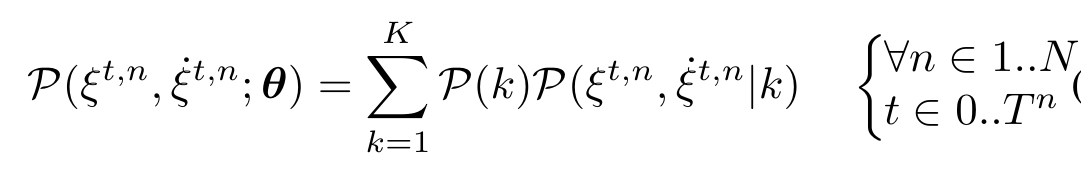

#### Conditional Probability:

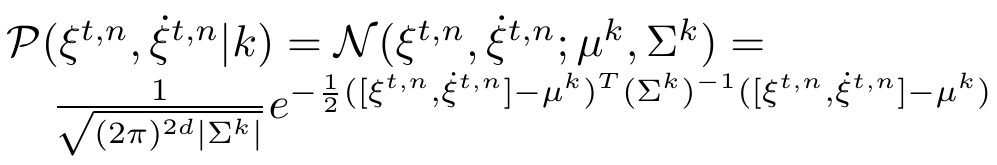

In [16]:
# joint probability of position and velocity:
# shape (n_samples, )
joint_prob = gmm.to_probability_density(traj_dynamics)

# objective function J:
obj_fun = -1 * np.sum(np.log(joint_prob))/ M

# conditional probability 'P' over priors, shape = (n_samples, n_components):
cond_prob = [MVN(traj_means[i], traj_covariances[i]).to_probability_density(traj_dynamics)\
                for i in range(gmm.n_components)]
cond_prob = np.column_stack((cond_prob[0], cond_prob[1]))

In [17]:
obj_fun

13927.902400073417

#### Derivatives w.r.t Priors $\pi^k:$

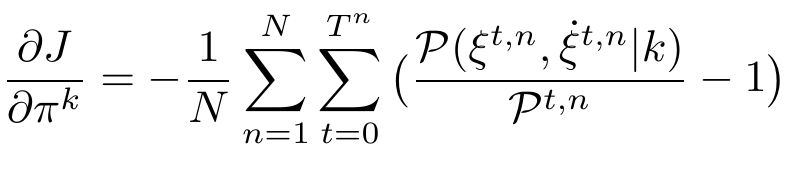

where, $\mathcal{P}^{t, n}$ = $\mathcal{P}(\xi^{t, n}, \dot \xi^{t, n};\theta)$

In [18]:
dJdPrior = [-1 * np.sum((cond_prob[:, k]/joint_prob) - 1) / M for k in range(gmm.n_components)]

#### Derivatives w.r.t Means $\mu_\xi^k:$

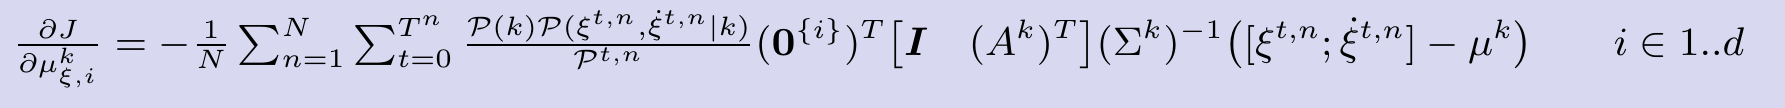

Calculating: $\frac{\mathcal{P}(k) \mathcal{P}(\xi^{t, n}, \dot \xi^{t, n};k)}{\mathcal{P}^{t, n}}$

In [19]:
# probability term for each GMM component:
prob_term = [traj_priors[:, k]*cond_prob[:, k]/joint_prob for k in range(gmm.n_components)]

Calculating $[\mathbf{I}\ \ \ (A^k)^T]_{d \times 2d}(\Sigma^k)^{-1}_{2d\times 2d}([x^{t, m} \ \ \dot x^{t, m}] - \mu^k)_{2d\times 1}$:

In [20]:
# dimension of the state space:
d = int(traj_dynamics.shape[1]/2)



# list of the matrices A for each component:
sigma_inv = [np.linalg.inv(traj_covariances[k]) for k in range(gmm.n_components)]
sigma_xx = [traj_covariances[k][:d, :d] for k in range(gmm.n_components)]
sigma_xdx = [traj_covariances[k][d:, :d] for k in range(gmm.n_components)]
mat_A = [np.matmul(sigma_xdx[k], np.linalg.inv(sigma_xx[k])) for k in range(gmm.n_components)]

# Indentity matrix and A matrix for each component:
concat_I_A = [np.concatenate((np.eye(d), mat_A[k].T), axis=1) for k in range(gmm.n_components)]

# trajectory - means, a list of 'k' arrays of shape (n_samples, d):
traj_minus_mean = [traj_dynamics - traj_means[k] for k in range(gmm.n_components)]

# multiplying all the matrices::
matrix_term = [concat_I_A[k] @ sigma_inv[k] @ traj_minus_mean[k].T\
               for k in range(gmm.n_components)] 

Calculating the final expression:
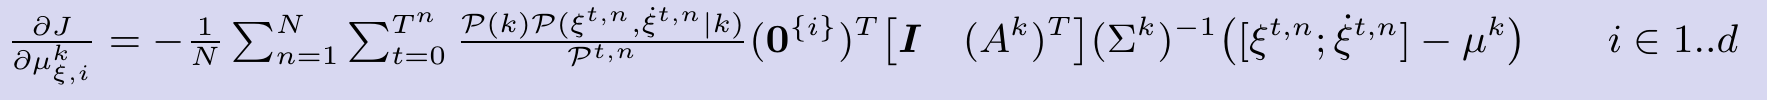

In [21]:
# derivative of with respect to means:
# this is a list of 'k' arrays, each array is of shape (d, )
dJdmean = [prob_term[k][:, np.newaxis].T @ matrix_term[k].T for k in range(gmm.n_components)]

#### Derivatives w.r.t covariances:

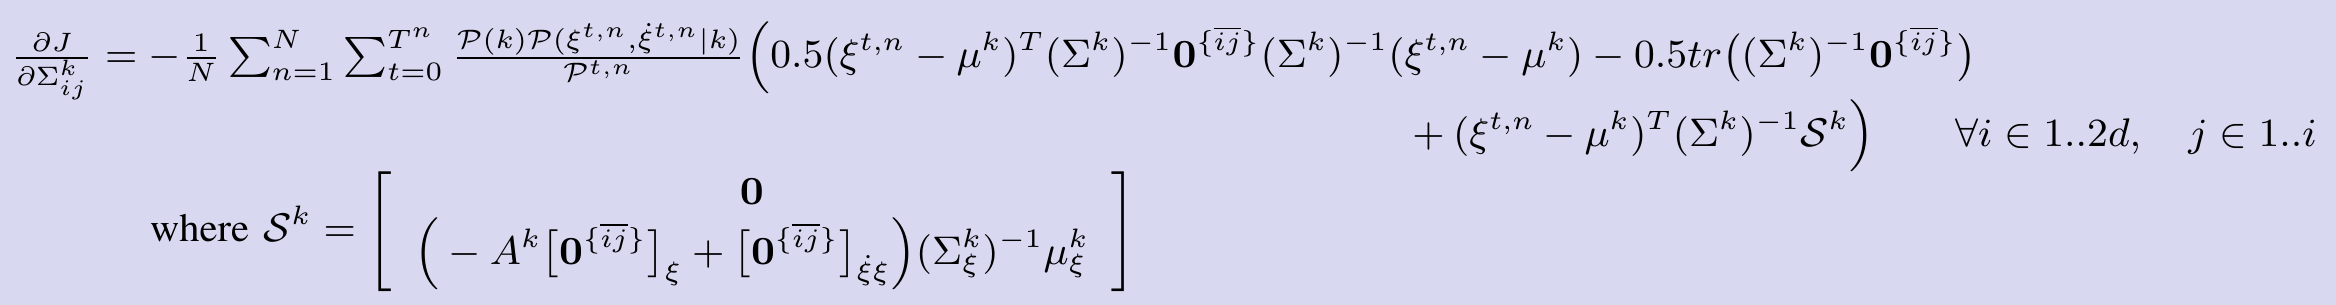

In [22]:
def dJ_dCovar(prob_term, traj_minus_mean, traj_means, sigma_inv, mat_A):
    vec_1 = [(traj_minus_mean[k] @ sigma_inv[k]) for k in range(gmm.n_components)]
    vec_2 = [(sigma_inv[k] @ traj_minus_mean[k].T).T for k in range(gmm.n_components)]
    zero_mat = np.zeros((vec_1[0].shape[1], vec_2[0].shape[1]))
    vec_Sk = np.zeros((vec_1[0].shape[1], 1))
    d = int(vec_Sk.shape[0]/2)
    result_mat = zero_mat.copy()
    derivatives = []
    for k in range(gmm.n_components):
        for i in range(vec_1[0].shape[1]):
            for j in range(i+1):
                zero_mat[i, j] = 1
                covar_term = (0.5 * (vec_1[k] @ zero_mat) * vec_2[k]).sum(axis=1)[:, np.newaxis]
                trace_term = 0.5 * np.trace(sigma_inv[k] @ zero_mat)
                vec_Sk[d:] = (-1 * mat_A[k] @ zero_mat[:d, :d] + zero_mat[d:, :d])\
                    @ (sigma_inv[k][:d, :d] @ traj_means[k][:d][:, np.newaxis])
                vec_Sk_term = vec_1[k] @ vec_Sk
                result_mat[i, j] = prob_term[k][:, np.newaxis].T \
                    @ (covar_term - trace_term + vec_Sk_term)
                zero_mat[i, j] = 0
        derivatives.append(result_mat + result_mat.T - np.diag(np.diag(result_mat)))
    return derivatives

In [23]:
a = zero_mat(prob_term, traj_minus_mean, traj_means, sigma_inv, mat_A)

In [24]:
a

[array([[-93.74169168, -14.7794067 , -39.56087459,  65.85074921],
        [-14.7794067 ,   2.01034663,   2.42132217,  -1.98099402],
        [-39.56087459,   2.42132217,  -5.7700046 ,  10.22562804],
        [ 65.85074921,  -1.98099402,  10.22562804, -40.55331099]]),
 array([[ 20.10448472,  21.52388529,  16.51034803, -22.45100412],
        [ 21.52388529, -31.75887635, -25.13852848,  31.14323839],
        [ 16.51034803, -25.13852848,  -1.29186759,   0.76849426],
        [-22.45100412,  31.14323839,   0.76849426,   0.12040861]])]